## PUI 2016 HOMEWORK 5, ASSIGNMENT 1
#### Ian Wright, iw453
#### October 2016

In [38]:
# for analysis
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
import scipy.stats as stats
import matplotlib.pyplot as plt
from getCitiBikeCSV import getCitiBikeCSV
%pylab inline
plt.style.use('ggplot')

# for reverse geocoding routine
import urllib, json
import csv

# relevant system environment vars
dataLand = os.getenv('PUIDATA')

Populating the interactive namespace from numpy and matplotlib


## Data collection & cleaning

In [3]:
# download two most recent months of citibike data to working directory
datestring1 = '201608'
datestring2 = '201609'
getCitiBikeCSV(datestring1)
getCitiBikeCSV(datestring2)

('Downloading', '201608')
file in place, you can continue
('Downloading', '201609')
file in place, you can continue


In [5]:
# read in the data from working directory
aug2016 = pd.read_csv(dataLand + '/' + datestring1 + '-citibike-tripdata.csv')
sep2016 = pd.read_csv(dataLand + '/' + datestring2 + '-citibike-tripdata.csv')

In [6]:
# concatenate the two months of data into one df
two_months = [aug2016, sep2016]
df = pd.concat(two_months, axis=0)
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [7]:
# drop the unnecessary columns
df.drop([u'tripduration', u'starttime', u'stoptime',
       u'start station name', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'gender'], axis=1, inplace=True)

In [8]:
df.head()

,start station id,start station latitude,start station longitude,birth year
0,302,40.720828,-73.977932,1961.0
1,285,40.734546,-73.990741,1989.0
2,539,40.715348,-73.960241,1971.0
3,280,40.733320,-73.995101,1995.0
4,161,40.729170,-73.998102,1993.0


In [9]:
df['age'] = df['birth year'].map(lambda birth: 2016 - birth)
df.head()

,start station id,start station latitude,start station longitude,birth year,age
0,302,40.720828,-73.977932,1961.0,55.0
1,285,40.734546,-73.990741,1989.0,27.0
2,539,40.715348,-73.960241,1971.0,45.0
3,280,40.733320,-73.995101,1995.0,21.0
4,161,40.729170,-73.998102,1993.0,23.0


In [10]:
# remove outliers
print 'max:', max(df['age'])
print 'min:', min(df['age'])

max: 131.0
min: 16.0


In [11]:
print 'original dataset size:',len(df)
# giving the elderly the benefit of the doubt here...
df = df[df['age'] < 90]
print 'trimmed dataset size:',len(df)

original dataset size: 3206519
trimmed dataset size: 2775120


### Reverse geocoding unique citibike stations

I'm going to use an online tool by Chris Bell (https://www.doogal.co.uk/BatchReverseGeocoding.php) to reverse geocode the lat-long starting coordinates of each citibike station into zip codes, and subsequently NYC burroughs.

In [12]:
# access citibike api endpoint to get a dict of all operating citibike stations in the city
url = "https://feeds.citibikenyc.com/stations/stations.json"
response = urllib.urlopen(url)
stations = json.loads(response.read())

In [13]:
# pare down the station dict to only the relevant fields
station_coord = [{'id':station['id'],
                 'latitude':station['latitude'],
                'longitude':station['longitude']} 
                for station in stations['stationBeanList']]

In [14]:
# write a csv file with this data --> will use in a reverse geocoder to get stations' zip codes
with open('stations_latlong.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=station_coord[0].keys())
    writer.writeheader()
    writer.writerows(station_coord)

I used a reverse geocoder to get a corresponding zip code for each station. The station-->zip mapping is in a small csv file 'station_zip_mapping.csv'

In [15]:
station_zip_map = pd.read_csv(dataLand + '/' + 'station_zip_mapping.csv')
print station_zip_map.head()
print len(station_zip_map), 'zips'

    id    zip
0   72  10019
1   79  10013
2   82  10038
3   83  11217
4  116  10011
664 zips


In [16]:
# make 6 lists of zip codes which make up each borough (split manhattan up and down)
bk_zips = [11201, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 
           11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 
           11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 
           11236, 11237, 11238, 11239, 11251, 11249]
queens_zips = [11001, 11004, 11005, 11040, 11096, 11101, 11102, 11103, 11104, 11105, 11106, 
               11109, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 
               11364, 11365, 11366, 11367, 11368, 11369, 11371, 11372, 11373, 11374, 11375, 
               11377, 11378, 11379, 11385, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 
               11418, 11419, 11420, 11421, 11422, 11423, 11426, 11427, 11428, 11429, 11430, 
               11432, 11433, 11434, 11435, 11436, 11451, 11691, 11692, 11694, 11697]
bronx_zips = [10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 
              10462, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 
              10475]
man_up_zips = [10036, 10017, 10022, 10111, 10115, 10019, 10020, 10069, 10023, 10065, 10021, 
               10075, 10028, 10128, 10029, 10024, 10025, 10026, 10027, 10035, 10031, 10030, 
               10037, 10039, 10032, 10033, 10040, 10034, 10044, 10155]
man_down_zips = [10004, 10280, 10006, 10005, 10038, 10048, 10281, 10007, 10282, 10013, 10002, 
                 10012, 10014, 10009, 10003, 10011, 10010, 10001, 10016, 10018, 10045, 10168]
staten_zips = [10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10312, 
               10314]

In [17]:
# map zips to borough
station_zip_map['Borough'] = 'Unknown'
for index, row in station_zip_map.iterrows():
    if row['zip'] in bk_zips:
        station_zip_map.set_value(index, 'Borough', 'Brooklyn')
    elif row['zip'] in queens_zips:
        station_zip_map.set_value(index, 'Borough', 'Queens')
    elif row['zip'] in man_up_zips:
        station_zip_map.set_value(index, 'Borough', 'ManhattanUpper')
    elif row['zip'] in man_down_zips:
        station_zip_map.set_value(index, 'Borough', 'ManhattanLower')
    elif row['zip'] in staten_zips:
        station_zip_map.set_value(index, 'Borough', 'Staten')
    elif row['zip'] in bronx_zips:
        station_zip_map.set_value(index, 'Borough', 'Bronx')
    else:
        pass

In [18]:
station_zip_map.head()

,id,zip,Borough
0,72,10019,ManhattanUpper
1,79,10013,ManhattanLower
2,82,10038,ManhattanLower
3,83,11217,Brooklyn
4,116,10011,ManhattanLower


In [19]:
# Finally, we can join this helper dataframe onto our original dataset
df_borr = df.merge(station_zip_map, how='left', left_on='start station id', right_on='id' )
df_borr.head()

,start station id,start station latitude,start station longitude,birth year,age,id,zip,Borough
0,302,40.720828,-73.977932,1961.0,55.0,302.0,10009.0,ManhattanLower
1,285,40.734546,-73.990741,1989.0,27.0,285.0,10003.0,ManhattanLower
2,539,40.715348,-73.960241,1971.0,45.0,539.0,11249.0,Brooklyn
3,280,40.733320,-73.995101,1995.0,21.0,280.0,10003.0,ManhattanLower
4,161,40.729170,-73.998102,1993.0,23.0,161.0,10012.0,ManhattanLower


In [20]:
# check if we're missing some zipcodes in our mapping
df_borr[df_borr['Borough']=='Unknown']['zip'].unique()

array([ 7306.])

In [21]:
# that looks like a garbage zip code, so we'll drop those records
print 'original length:', len(df_borr)
df_borr = df_borr[df_borr['zip'] != 7306.]
print 'trimmed length:', len(df_borr)

original length: 2775120
trimmed length: 2771797


In [22]:
# and we can drop all columns except for age and borough
df = df_borr.drop([u'start station id', u'start station latitude',
       u'start station longitude', u'birth year', u'id', u'zip'], axis=1)
df.head()

,age,Borough
0,55.0,ManhattanLower
1,27.0,ManhattanLower
2,45.0,Brooklyn
3,21.0,ManhattanLower
4,23.0,ManhattanLower


## Fitting the data with a Gaussian (Normal) curve
(credit to this stackoverflow thread for information on fitting curves with scipy: http://stackoverflow.com/questions/11507028/fit-a-gaussian-function)

In [25]:
# NOTE - there is obviously a shorter way to fit a normal curve to a dataset... 
# but this was a learning experience?

# to fit our age distribution to a normal curve, we first need to put it into a set of bins (a histogram)
# using bins of size 1, for each age in the distribution
edges = np.arange(min(df['age']), max(df['age']) + 1, 1)
age_counts, age_bin_edges = np.histogram(df['age'], bins=edges)

# the x-values for the distribution will be "left edges" of the bins (just the age integer)
ages = age_bin_edges[:-1]

In [26]:
ages

array([ 16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
        60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
        71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
        82.,  83.,  84.])

In [27]:
# look at the data so we can have an educated guess about the gaussian distribution's parameters
print stats.describe(df['age'])
print max(age_counts)

DescribeResult(nobs=2771797, minmax=(16.0, 85.0), mean=37.560386998037735, variance=130.92240469503332, skewness=0.7218227504191055, kurtosis=-0.17370903596911136)
121956


We know the gaussian function to have three parameters:
![Gaussian Function](https://wikimedia.org/api/rest_v1/media/math/render/svg/9e401667431be9984c7a01192a6329be14d641f1)
Where 
+ a = curve height (amplitude)
+ b = mean
+ c = standard deviation

In [28]:
# let's define that curve in python code
def gauss(x, *args):
    a, mu, sigma = args
    return a*np.exp(-((x-mu)**2)/(2.*sigma**2))

To fit the curve, we'll use scipy.curve_fit(), which takes 4 args:
+ a function to fit to our dataset (in this case, gaussian function)
+ dataset x values; the centerpoints of our histogram bins along the x axis
+ dataset y values; the frequencies (size) from the histogram bins of our data
+ intitial guess for function parameters; a, mu, and sigma
And returns an array of coefficients for the fitted curve, and a covariance matrix

In [29]:
# define an initial guess for (a, mu, sigma)
coeffs_0 = [60000, 38, np.sqrt(129)]

In [30]:
# fit the gaussian
coeffs_fit, covar_fit = curve_fit(gauss, ages, age_counts, p0=coeffs_0)
fitted_curve = gauss(ages, *coeffs_fit)

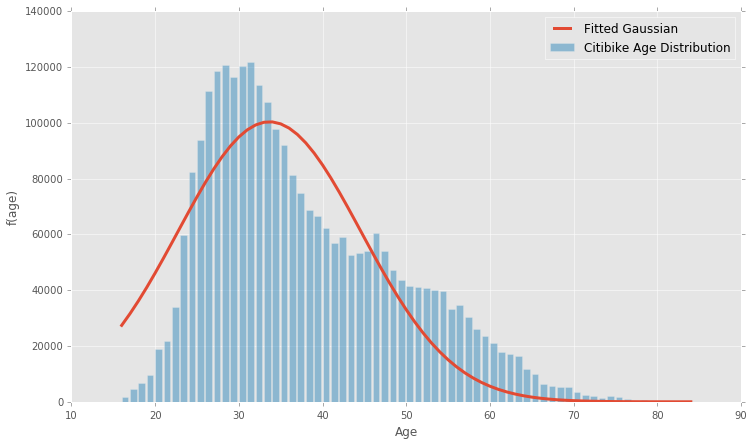

Gaussian parameters (a, mu, sigma): [  1.00369769e+05   3.36579541e+01   1.09580895e+01]


In [31]:
# plot the sample distribution against the fitted normal curve
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
ax.plot(ages, fitted_curve, label='Fitted Gaussian', linewidth=3)
ax.bar(ages, age_counts, label='Citibike Age Distribution', alpha=0.5)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('f(age)')
plt.show()

print 'Gaussian parameters (a, mu, sigma):', coeffs_fit

#### Figure 1: Citibike age distribution with a fitted Gaussian curve

## Assessing goodness of fit for Gaussian/Normal curve

### Kolmogorov-Smirnov (KS) Test

scipy's one-sample KS-test compares a given sample against a known STANDARDIZED normal distribution (which means sigma=1, mu=0). So before we make the comparison, we need to normalize our age array using the gaussian paramters we just fit.

In [32]:
standardized_age = (df['age'] - coeffs_fit[1]) / coeffs_fit[2]

#### $H_0$: The standardized distribution of citibike rider age is IDENTICAL to a regular standard normal distribution of mean 0 and standard deviation 1; $\alpha = 0.05$

In [33]:
# to illustrate the difference of the KS test for both the standardized and non-standardized datasets, show both:
print stats.kstest(df['age'], 'norm')
print stats.kstest(standardized_age, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.13226932837116445, pvalue=0.0)


We reject the null if: $D > \frac{1.36}{\sqrt{N}}$

Our N is large (2.8M), so our D statistic is certainly larger than this critical value (0.001). We can safely REJECT the null hypothesis that citibike rider ages are distributed normally at $\alpha = 0.05$

Small p-value (approaching zero) re-enforces the rejection of null.

### Anderson-Darling (AD) Test

The null hypothesis is the same:
#### $H_0$: The standardized distribution of citibike rider age is IDENTICAL to a regular standard normal distribution of mean 0 and standard deviation 1; $\alpha = 0.05$

In [41]:
print stats.anderson(standardized_age, 'norm')

AndersonResult(statistic=48880.548550393898, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


For this test, the critical value depends on the assumed distribution and confidence level. At alpha=0.05, we see the critical value is 0.787. Our AD statistic is MUCH higher than the critical value, so again we REJECT the null hypothesis that citibike rider age is drawn from a normal distribution.

## Fitting the data with a Log-Normal curve

We know the lognormal function to have two parameters:
![Gaussian Function](https://wikimedia.org/api/rest_v1/media/math/render/svg/f28880971cb6d8b20b541b4943e518f190528bf2)
Where 
+ mu = mean
+ sigma = standard deviation

But instead of coding the lognorm function by hand and using curve_fit(), this time we'll just use built-in lognorm functionality from scipy (way faster).

In [42]:
# fit a lognormal curve to our age data
lognormal_params_fitted = stats.lognorm.fit(df['age'])
print 'Log-Normal params (scatter, mean, sd):', lognormal_params_fitted

Log-Normal params (scatter, mean, sd): (0.41410996141532597, 9.8194100388763861, 25.499417811812407)


For our regular normal distribution, we had a parameter 'a' that acted as a multiplier to the whole distribution... it meant that we didn't need to normalize our histogram into a sum=1 distribution.

For the lognormal distribution, there is no such parameter, and so to compare the fitted lognormal PDF to our sample data, we first need to "normalize" our binned sample data.

In [43]:
# normalize our real age distribution so that total area = 1
age_counts_normal = age_counts.astype(float) / float(age_counts.sum())

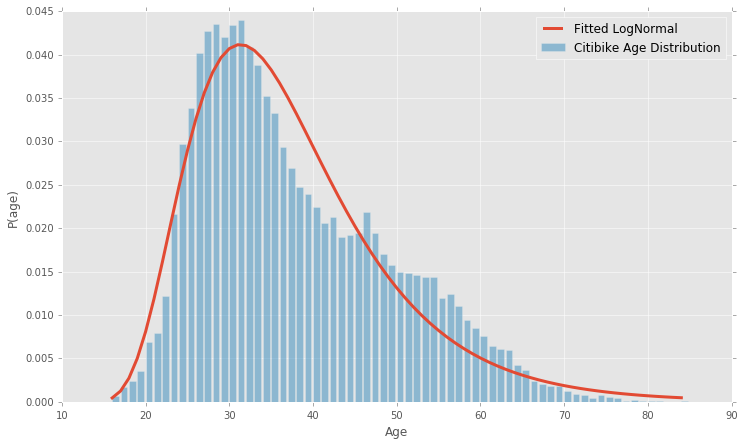

In [46]:
# plot the sample distribution against the fitted LOGNORMAL curve
fig, ax = plt.subplots()
fig.set_size_inches(12,7)

# generate a curve that represents the fitted lognormal PDF
lognormal_fitted = stats.lognorm.pdf(ages, 
                               lognormal_params_fitted[0], 
                               loc=lognormal_params_fitted[1], 
                               scale=lognormal_params_fitted[2])
ax.plot(ages, lognormal_fitted, label='Fitted LogNormal', linewidth=3)
ax.bar(ages, age_counts_normal, label='Citibike Age Distribution', alpha=0.5)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('P(age)')
plt.show()

#### Figure 2: Citibike age distribution with a fitted Log-Normal curve

## Assessing goodness of fit for Log-Normal curve

### Kolmogorov-Smirnov (KS) Test

#### $H_0$: The distribution of normalized citibike rider age is IDENTICAL to a LogNormal distribution; $\alpha = 0.05$

In [48]:
print stats.kstest(df['age'], 'lognorm', lognormal_params_fitted)

KstestResult(statistic=0.049571912212266867, pvalue=0.0)


We reject the null if: $D > \frac{1.36}{\sqrt{N}}$

Again, our N is large, so our D statistic is certainly larger than this critical value (approx 0.001). We can safely REJECT the null hypothesis that citibike rider ages are distributed Log-Normally at $\alpha = 0.05$

Small p-value (approaching zero) re-enforces the rejection of null.

#### HOWEVER, it should be noted that this is a far better fit (even if we can't say it's a true log-normal distribution), than the standard normal distribution fit. We can tell the fit is better both visually (Fig. 2), and because our KS-test D-statistic is much smaller than for normal distribution.

### Anderson-Darling (AD) Test

The null hypothesis is the same:
#### $H_0$: The distribution of normalized citibike rider age is IDENTICAL to a LogNormal distribution; $\alpha = 0.05$

The Anderson-Darling test can't compute goodness of fit for log-normal distributions (only regular normal), so we need to calculate the logarithm of each age in our sample, and treat the test as if it's a regular normal distribution:

In [49]:
log_age = np.log(df['age'])

In [52]:
print stats.anderson(log_age, 'norm')

AndersonResult(statistic=15863.523697061464, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


The result is similar! Our critical value for alpha=0.05 is 0.787, which is much smaller than our AD statistic of 15,863. We REJECT the null hypothesis that the ages of citibike riders are log-normal distributed.

HOWEVER, this AD result is still a lot better than that of the regular normal distribution; the statistic, though not critical, is much lower here.

It may be sensible to conclude that log-normal is a "reasonable" estimate of the distribution.

## EXTRA CREDIT

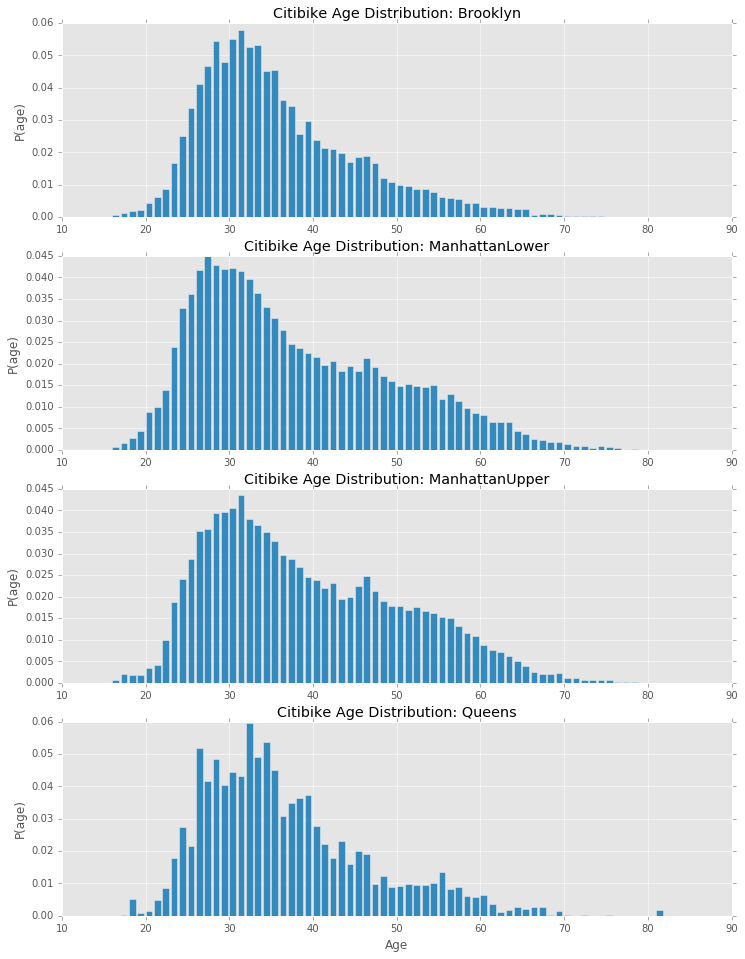

In [65]:
# group citibike dataset by borough
dfg = df.groupby('Borough')

# first, let's visualize the distribution for each burough
fig, axarr = plt.subplots(4,1)
fig.set_size_inches(12,16)

plot_index = 0
for borough, group in dfg:
    # group histogram
    edges = np.arange(min(group['age']), max(group['age']) + 1, 1)
    age_counts, age_bin_edges = np.histogram(group['age'], bins=edges)
    age_counts_normal = age_counts.astype(float) / float(age_counts.sum())
    ages = age_bin_edges[:-1]
    
    # group plotting routine
    ax = axarr[plot_index]
    ax.bar(ages, age_counts_normal)
    ax.set_ylabel('P(age)')
    if plot_index == 3:
        ax.set_xlabel('Age')
    ax.set_title('Citibike Age Distribution: ' + borough)
    
    # increment the subplot index
    plot_index += 1

plt.show()

There don't seem to be any huge differences in distribution across buroughs. The tail on the Brooklyn does look smoother and more log-normal than the rest. Let's try to fit the Brooklyn distribution with a lognormal curve to see if we can get a better fit than overall.

In [85]:
# isolate brooklyn datapoints
bk_age = dfg.get_group('Brooklyn')['age']

# fit a lognormal curve to our age data
bk_lognormal_params = stats.lognorm.fit(bk_age)
print 'Log-Normal params (scatter, mean, sd):', bk_lognormal_params

Log-Normal params (scatter, mean, sd): (0.36657091594243552, 10.556250295564082, 23.279412874188335)


In [86]:
# generate histogram data for Brooklyn age distribution
edges = np.arange(min(bk_age), max(bk_age) + 1, 1)
bk_age_counts, bk_age_bin_edges = np.histogram(bk_age, bins=edges)
bk_age_normal = bk_age_counts.astype(float) / float(bk_age_counts.sum())
bk_ages = bk_age_bin_edges[:-1]

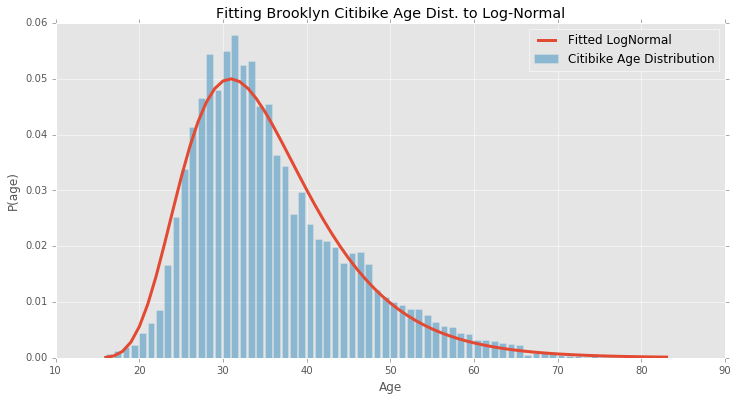

In [89]:
# plot the sample distribution against the fitted LOGNORMAL curve
fig, ax = plt.subplots()
fig.set_size_inches(12,6)

# generate a curve that represents the fitted lognormal PDF
bk_lognormal_fitted = stats.lognorm.pdf(bk_ages, 
                               bk_lognormal_params[0], 
                               loc=bk_lognormal_params[1], 
                               scale=bk_lognormal_params[2])
ax.plot(bk_ages, bk_lognormal_fitted, label='Fitted LogNormal', linewidth=3)
ax.bar(bk_ages, bk_age_normal, label='Citibike Age Distribution', alpha=0.5)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('P(age)')
ax.set_title('Fitting Brooklyn Citibike Age Dist. to Log-Normal')
plt.show()

### Testing goodness of fit with a KS-test

In [90]:
print stats.kstest(bk_age, 'lognorm', bk_lognormal_params)

KstestResult(statistic=0.049887004784214151, pvalue=0.0)


Unfortunately, this D-Statistic is about the same as that of the overall distribution. We must reject the null hypothesis that the age of Brooklyn Citibike riders is drawn from a log-normal distribution; $\alpha=0.05$, as the stat is much higher than critical value, and p-value is approx. zero.